In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn as nn
from datetime import datetime
import math


In [2]:
batch_size =32
seq_len = 96
pre_len = 96
learning_rate = 0.005
train_epoch = 10
period = 4
size = [seq_len,pre_len]
transformer_dim=128
target = 'M' #MS

dataset = 'ETTh1'   
dataset_root= './{}.csv'.format(dataset)
checkpoint_path = './{}_weight/{}/'.format(dataset,pre_len)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Dataset_Custom_train(Dataset):
    def __init__(self,  flag):     
        self.seq_len = seq_len    
        self.pre_len = pre_len
        
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]
        
        self.features = 'M'
        self.target = 'OT'
        self.scale = True
        
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(dataset_root,parse_dates=['date'])

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''

        cols = list(df_raw.columns)
            
        cols.remove('date')
        num_train = int(len(df_raw) * (0.7))
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        df_data = df_raw[cols]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
    
        self.data_x = data[border1:border2]
   
        #STL
        STL_Data = pd.DataFrame(self.data_x) 
        self.s,self.t,self.l = self.stl(STL_Data)

    def stl(self,STL_Data):
        cols = STL_Data.columns
        channels = len(cols)

        s = torch.zeros([len(STL_Data), channels], dtype=torch.float32)
        t = torch.zeros([len(STL_Data), channels], dtype=torch.float32)
        l = torch.zeros([len(STL_Data), channels], dtype=torch.float32)

        for i ,col in enumerate(cols):
            df = STL_Data[col]   
            res = STL(df, period=period).fit()  
            s[:, i] = torch.tensor(np.array(res.seasonal.values), dtype=torch.float32)
            t[:, i] = torch.tensor(np.array(res.trend.values), dtype=torch.float32)
            l[:, i] = torch.tensor(np.array(res.resid.values), dtype=torch.float32)
        return s,t,l

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        
        r_begin = s_end 
        r_end = r_begin + self.pre_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_x[r_begin:r_end]
             
        #global_stl
        s = self.s[s_begin:s_end]
        t = self.t[s_begin:s_end]
        l = self.l[s_begin:s_end]
        global_stl = (s,t,l)
        
        #local_stl
        s1,t1,l1 =  self.stl(pd.DataFrame(seq_x))
        local_stl = (s1,t1,l1)

        return seq_x, seq_y, global_stl,local_stl
    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pre_len + 1




In [4]:
def data_provider(flag):
    Data = Dataset_Custom_train   
    train_only = False
    if flag == 'test':
        shuffle_flag = False
        drop_last = False
        
    else:
        shuffle_flag = True
        drop_last = True
        

    data_set = Data(
        flag='train'   
    )
     
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=0,
        drop_last=True)
    return data_set, data_loader

def _get_data(flag):
    data_set, data_loader = data_provider(flag)
    return data_set, data_loader

In [5]:
class Rescontruct_F(nn.Module):
    def __init__(self,):
        super(Rescontruct_F, self).__init__()
        # Nlinear
        self.Linear1 = nn.Linear(seq_len, seq_len).to(device)
        
        #Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim,
                                                        nhead=8,
                                                        dropout=0.1,
                                                        batch_first=True).to(device)
        
        self.Transnformer_encoder = nn.TransformerEncoder(self.encoder_layer,
                                                   num_layers=3).to(device)
        self.Linear2 = nn.Linear(seq_len,transformer_dim)
        self.Linear3 = nn.Linear(transformer_dim,seq_len)

    def forward(self, x, flag):
        if flag == "Nlinear":
            seq_last = x[:, -1:, :].detach()
            x = x - seq_last
            x = self.Linear1(x.permute(0, 2, 1)).permute(0, 2, 1)
            x = x + seq_last
            return x
        if flag == "Encoder":
            x = self.Linear2(x.permute(0, 2, 1))
            x = self.Transnformer_encoder(x)
            x = self.Linear3(x).permute(0, 2, 1)    
            return x



In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()      
        # re
        self.Rescontruct_F = Rescontruct_F().to(device)
        
        # pre
        self.l1 = nn.Linear(seq_len, pre_len).to(device)
        self.l2 = nn.Linear(seq_len, pre_len).to(device)


    def forward(self, x,flag):
        if flag == "pre":       
            s,l,t = x         
            seq_last_t = t[:, -1:, :].detach()
            t = t - seq_last_t
            t = self.l1(t.permute(0, 2, 1)).permute(0, 2, 1)
            t = t + seq_last_t
            
            seq_last_s = s[:, -1:, :].detach()
            s = s - seq_last_s
            s = self.l2(s.permute(0, 2, 1)).permute(0, 2, 1)
            s = s + seq_last_s
            x = s+t         
            return x
        if flag == "Reconstruct":
            s, t, l = x   
            Reconstruct_list = []
            
            R_s = self.Rescontruct_F(s, flag = "Nlinear")
            Reconstruct_list.append(R_s)
            
            R_l = self.Rescontruct_F(l, flag = "Nlinear")
            Reconstruct_list.append(R_l)
            
             
            R_t = self.Rescontruct_F(t, flag = "Encoder")
            Reconstruct_list.append(R_t)
         
            return Reconstruct_list


In [7]:
model = MLP().to(device)

In [8]:
def train(model):
    train_data, train_loader = _get_data(flag='train')
    vali_data, vali_loader = _get_data(flag='val')
    model_optim = optim.Adam(model.parameters(),lr=0.001)
    criterion = nn.MSELoss()
    model.train()     
    
    for epoch in range(train_epoch):     
        r_s_loss =[]
        r_t_loss =[]
        r_l_loss =[]
        r_total_loss = []
        
        pre_epoch_loss = []
        
        #draw
        r_s1_draw =[]
        r_t1_draw =[]
        r_l1_draw =[]
        
        g_s_draw =[]
        g_t_draw =[]
        g_l_draw =[]
        
        pre_draw = []
        y_draw = []
        
        
        for i, (x, y, global_stl,local_stl) in enumerate(train_loader):      
            s,t,l = global_stl
            s1,t1,l1 = local_stl          

            #reconstruction input
            s1 = s1.float().to(device)
            t1 = t1.float().to(device)
            l1 = l1.float().to(device)
            
            s = s.float().to(device)
            t = t.float().to(device)
            l = l.float().to(device)
            
            x = x.float().to(device)
            #reconstruction 
            input1 = (s1,t1,l1)
            r_s1, r_l1, r_t1= model(input1,flag = "Reconstruct")
            
            #pre
            input2 = (r_s1, r_l1, r_t1)
            pre_result = model(input2,flag = "pre")
            
            r_loss1 = criterion(r_s1, s) 
            r_loss2 = criterion(r_t1, t) 
            r_loss3 = criterion(r_l1, l) 
            r_loss = r_loss1 + r_loss2 + r_loss3
            
            f_dim = -1 if target== 'MS' else 0
            pre_result = pre_result[:, -pre_len:, f_dim:]
            y = y[:, -pre_len:, f_dim:]
            
            
            #pre 
            y = y.float().to(device)     
            pre_loss = criterion(pre_result,y)
            
            #梯度下降
            loss = r_loss + pre_loss         
            model_optim.zero_grad()   
            loss.backward()
            model_optim.step()
            #print loss
            r_s_loss.append(r_loss1.item())
            r_t_loss.append(r_loss2.item())
            r_l_loss.append(r_loss3.item())
            r_total_loss.append(r_loss.item())
            
            pre_epoch_loss.append(pre_loss.item())
            #draw reconstruction
            r_s1_draw.append(r_s1[0,:,-1].detach().cpu().numpy())
            r_t1_draw.append(r_t1[0,:,-1].detach().cpu().numpy())
            r_l1_draw.append(r_l1[0,:,-1].detach().cpu().numpy())
            
            g_s_draw.append(s[0,:,-1].detach().cpu().numpy())
            g_t_draw.append(t[0,:,-1].detach().cpu().numpy())
            g_l_draw.append(l[0,:,-1].detach().cpu().numpy())
            
            #draw prediction
            pre_draw.append(pre_result[0,:,-1].detach().cpu().numpy())
            y_draw.append(y[0,:,-1].detach().cpu().numpy())
  
        r_total_loss = np.average(r_total_loss)
        r_s_loss = np.average(r_s_loss)
        r_t_loss = np.average(r_t_loss)
        r_l_loss = np.average(r_l_loss)
        pre_epoch_loss = np.average(pre_epoch_loss)

        print("{}".format(dataset),"train epoch:",epoch,"  r_total_loss:",r_total_loss,"  s,t,l: ",r_s_loss,r_t_loss,r_l_loss," pre_loss:",pre_epoch_loss)
        
        r_s1_draw = np.concatenate(r_s1_draw, axis=0)
        r_t1_draw = np.concatenate(r_t1_draw, axis=0)
        r_l1_draw = np.concatenate(r_l1_draw, axis=0)
        
        g_s_draw = np.concatenate(g_s_draw, axis=0)
        g_t_draw = np.concatenate(g_t_draw, axis=0)
        g_l_draw = np.concatenate(g_l_draw, axis=0)
        
        pre_draw = np.concatenate(pre_draw, axis=0)
        y_draw = np.concatenate(y_draw, axis=0)
        
        draw_length= -96
        #
        plt.subplots(figsize=(10, 10))
        plt.subplot(411)
        plt.xticks([])
        plt.plot(r_s1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_s_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_S')   
       
        plt.subplot(412)
        plt.xticks([])
        plt.plot(r_t1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_t_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_T')
        
        plt.subplot(413)
        plt.xticks([])
        plt.plot(r_l1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_l_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_L')
        
                
        plt.subplot(414) 
        plt.plot(pre_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(y_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('pre_result')
        plt.show()
    
    
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path, exist_ok=True)
        
    torch.save(model.state_dict(),checkpoint_path+"checkpoint.pth")    
    return model
        #vali_loss = vali(vali_data,vali_loader)

In [9]:
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
print("train start：", formatted_time)

train start： 2024-07-04 15:00:42


ETTh1 train epoch: 0   r_total_loss: 0.1480403966009617   s,t,l:  0.009470828843613466 0.11414390392104784 0.024425663982828458  pre_loss: 0.41357906452814736


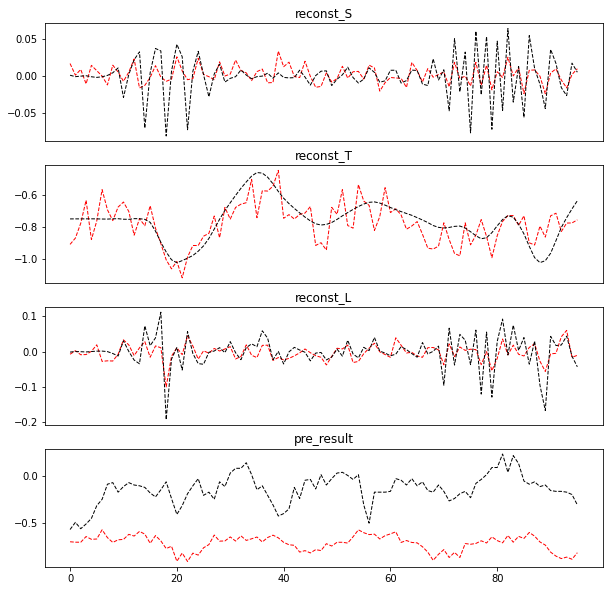

ETTh1 train epoch: 1   r_total_loss: 0.05796529999375343   s,t,l:  0.003853071201592684 0.04551640754938126 0.008595821219185989  pre_loss: 0.34273455500602723


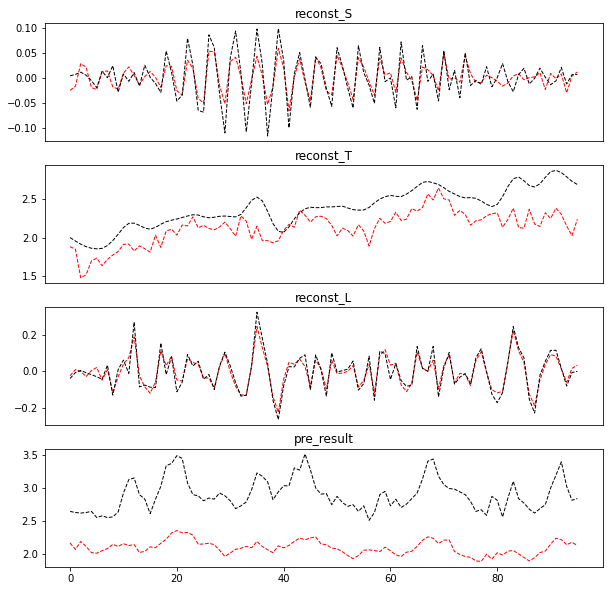

ETTh1 train epoch: 2   r_total_loss: 0.043900261506438255   s,t,l:  0.002138275078187386 0.03764659137527148 0.004115395120655497  pre_loss: 0.320200254480044


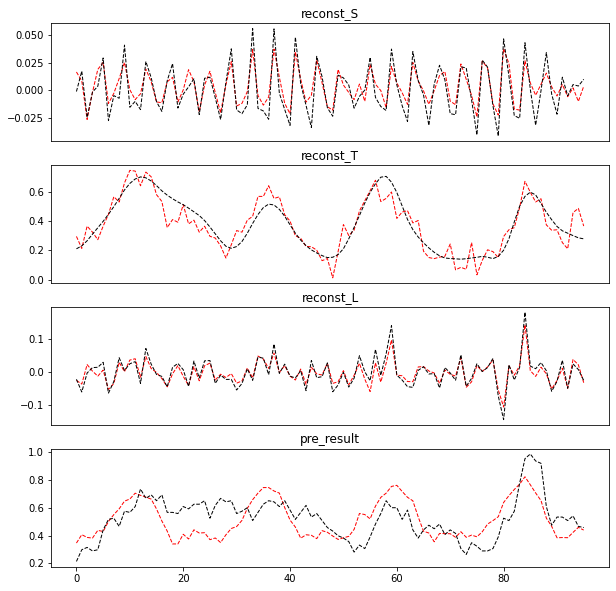

ETTh1 train epoch: 3   r_total_loss: 0.03663009675343831   s,t,l:  0.0013739174514388044 0.03283423033853372 0.0024219489553943276  pre_loss: 0.2948132319053014


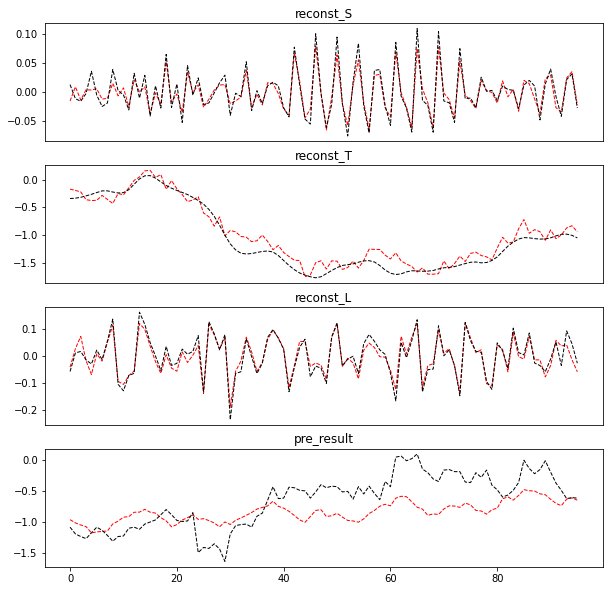

ETTh1 train epoch: 4   r_total_loss: 0.033387067606051764   s,t,l:  0.0009822090544427434 0.03065843283633391 0.001746425723657012  pre_loss: 0.2735832854111989


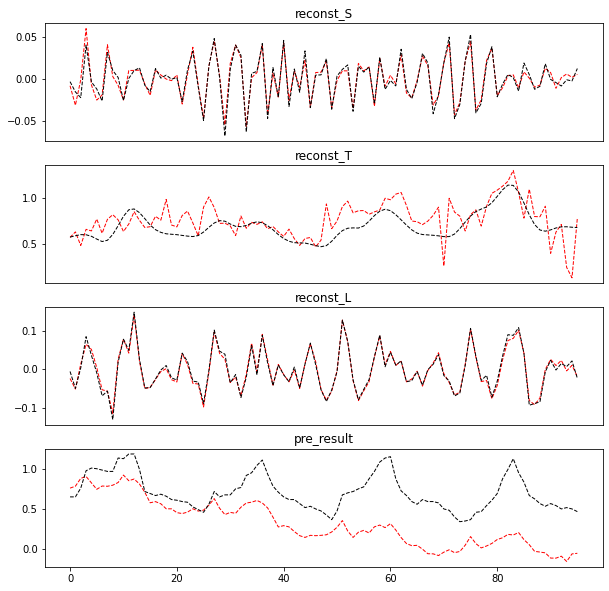

ETTh1 train epoch: 5   r_total_loss: 0.031462108835577964   s,t,l:  0.0008337037009187042 0.02914457354446252 0.0014838315872475504  pre_loss: 0.25826559782028197


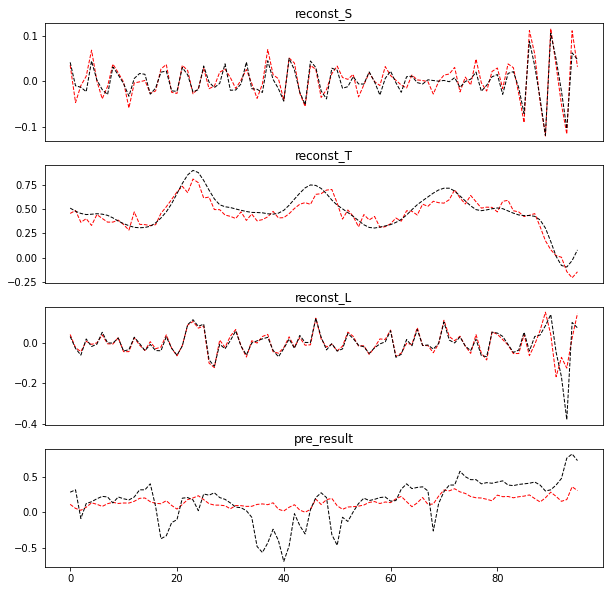

ETTh1 train epoch: 6   r_total_loss: 0.029381383885939916   s,t,l:  0.0007344452703061203 0.027295209462443987 0.0013517292216420173  pre_loss: 0.2432678104241689


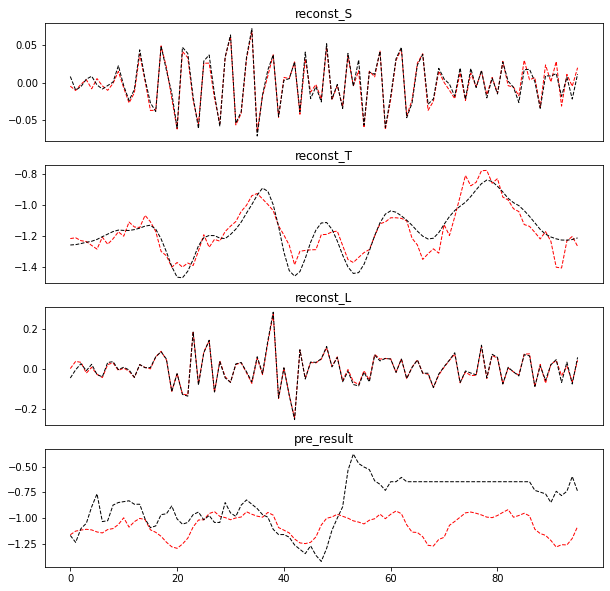

ETTh1 train epoch: 7   r_total_loss: 0.028657915805776913   s,t,l:  0.0007043281844817102 0.026660253003239633 0.001293334562331438  pre_loss: 0.2302562668720881


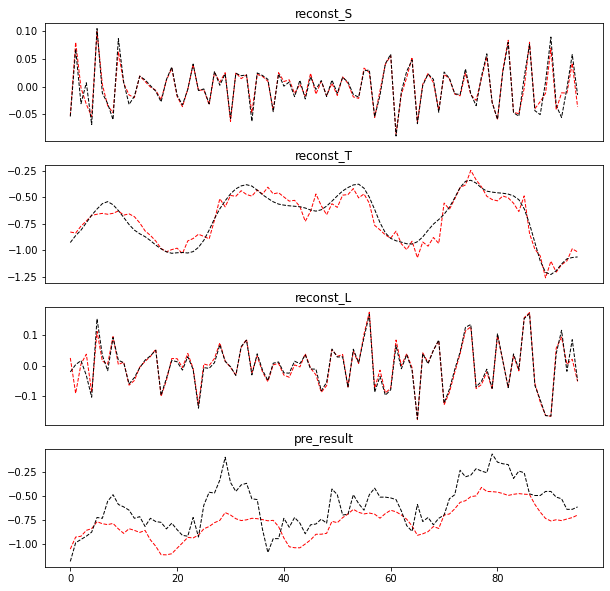

ETTh1 train epoch: 8   r_total_loss: 0.027659658685326577   s,t,l:  0.0006957203925897678 0.025698315208156904 0.0012656231368891894  pre_loss: 0.2181545487244924


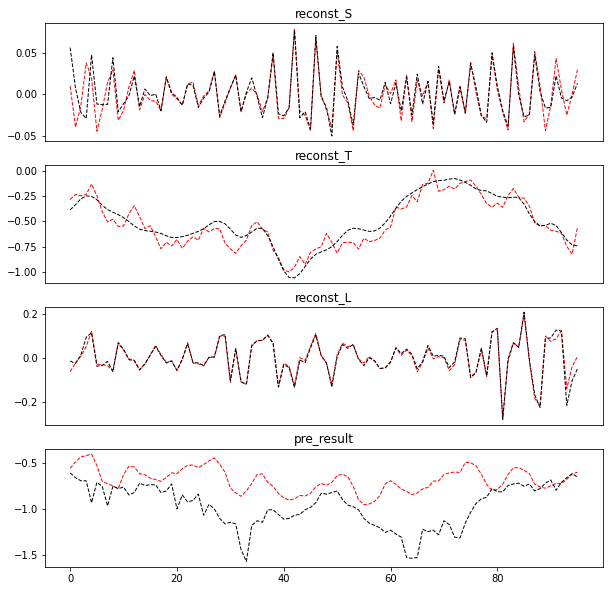

ETTh1 train epoch: 9   r_total_loss: 0.02961631486316522   s,t,l:  0.0006729163727723062 0.027705527409911154 0.0012378709819167851  pre_loss: 0.2179079978466034


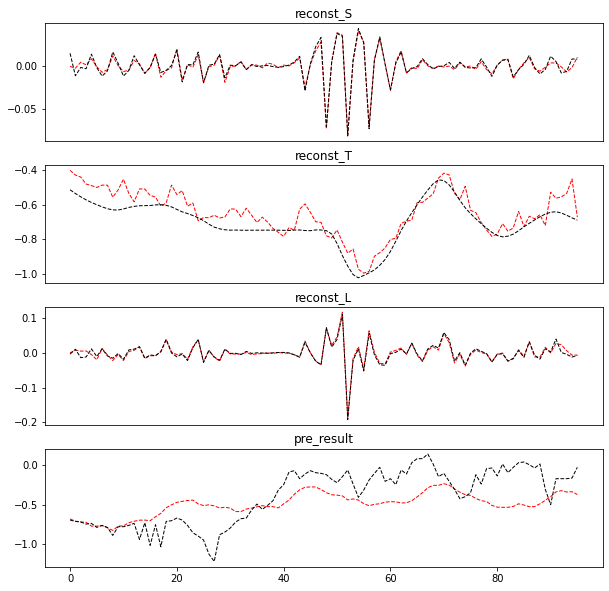

In [10]:
train_model = train(model)

In [11]:
def test(train_model):
    test_data, test_loader = _get_data(flag='test')
    criterion = nn.MSELoss()
    train_model.eval()
    with torch.no_grad():
        r_s_loss =[]
        r_t_loss =[]
        r_l_loss =[]
        r_total_loss = []
        pre_epoch_loss = []
        
        #draw  
        r_s1_draw =[]
        r_t1_draw =[]
        r_l1_draw =[]
        
        g_s_draw =[]
        g_t_draw =[]
        g_l_draw =[]
        
        pre_draw = []
        y_draw = []
        
        preds = []
        trues = []
        for i, (x, y,global_stl,local_stl) in enumerate(test_loader):  
            s,t,l = global_stl
            s1,t1,l1 = local_stl       

            #reconstruction input
            s1 = s1.float().to(device)
            t1 = t1.float().to(device)
            l1 = l1.float().to(device)
            x = x.float().to(device)
            
            
            s = s.float().to(device)
            t = t.float().to(device)
            l = l.float().to(device)
            
            
            #reconstruction 
            input1 = (s1,t1,l1)
            r_s1, r_l1, r_t1 = model(input1,flag = "Reconstruct")
            
            #pre
            input2 = (r_s1, r_l1, r_t1)
            pre_result = model(input2,flag = "pre")
            
            r_loss1 = criterion(r_s1, s) 
            r_loss2 = criterion(r_t1, t) 
            r_loss3 = criterion(r_l1, l) 
            r_loss = r_loss1 + r_loss2 + r_loss3
            
                        
            f_dim = -1 if target== 'MS' else 0
            pre_result = pre_result[:, -pre_len:, f_dim:]
            y = y[:, -pre_len:, f_dim:].float().to(device) 
            
            pre_loss = criterion(pre_result,y)
            
            #print loss
            r_s_loss.append(r_loss1.item())
            r_t_loss.append(r_loss2.item())
            r_l_loss.append(r_loss3.item())
            r_total_loss.append(r_loss.item())
            pre_epoch_loss.append(pre_loss.item())

            
            #draw reconstruction
            r_s1_draw.append(r_s1[0,:,-1].detach().cpu().numpy())
            r_t1_draw.append(r_t1[0,:,-1].detach().cpu().numpy())
            r_l1_draw.append(r_l1[0,:,-1].detach().cpu().numpy())
            
            g_s_draw.append(s[0,:,-1].detach().cpu().numpy())
            g_t_draw.append(t[0,:,-1].detach().cpu().numpy())
            g_l_draw.append(l[0,:,-1].detach().cpu().numpy())
            
            #draw prediction
            pre_draw.append(pre_result[0,:,-1].detach().cpu().numpy())
            y_draw.append(y[0,:,-1].detach().cpu().numpy())
            
           
            
            #mse,mae
            pre_result = pre_result.detach().cpu().numpy()

            y = y.detach().cpu().numpy()
            
            preds.append(pre_result)
            trues.append(y)
            

                
        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)
        mae = np.mean(np.abs(preds - trues))
        mse = np.mean((preds - trues) ** 2)
        print('mse:{}, mae:{}'.format(mse, mae))
                

        train_r_loss = np.average(r_total_loss)
        r_s_loss = np.average(r_s_loss)
        r_t_loss = np.average(r_t_loss)
        r_l_loss = np.average(r_l_loss)
        pre_epoch_loss = np.average(pre_epoch_loss)


        print("{}".format(dataset),"test:","  r_loss:",train_r_loss,"  s,t,l: ",r_s_loss,r_t_loss,r_l_loss," pre_loss:",pre_epoch_loss)
        
        #draw
        r_s1_draw = np.concatenate(r_s1_draw, axis=0)
        r_t1_draw = np.concatenate(r_t1_draw, axis=0)
        r_l1_draw = np.concatenate(r_l1_draw, axis=0)
        
        g_s_draw = np.concatenate(g_s_draw, axis=0)
        g_t_draw = np.concatenate(g_t_draw, axis=0)
        g_l_draw = np.concatenate(g_l_draw, axis=0)
        
        pre_draw = np.concatenate(pre_draw, axis=0)
        y_draw = np.concatenate(y_draw, axis=0)
        
        draw_length= -96
        plt.subplots(figsize=(10, 10))
        plt.subplot(411)
        plt.xticks([])
        plt.plot(r_s1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_s_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_S')   
       
        plt.subplot(412)
        plt.xticks([])
        plt.plot(r_t1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_t_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_T')
        
        plt.subplot(413)
        plt.xticks([])
        plt.plot(r_l1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_l_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_L')
                 
        plt.subplot(414)
        plt.xticks([])
        plt.plot(pre_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(y_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('pre_result')
        plt.show()
        

mse:0.18932609260082245, mae:0.31464263796806335
ETTh1 test:   r_loss: 0.020120674155652524   s,t,l:  0.0006516206731709341 0.01825292895672222 0.0012161245062792053  pre_loss: 0.1893260664542516


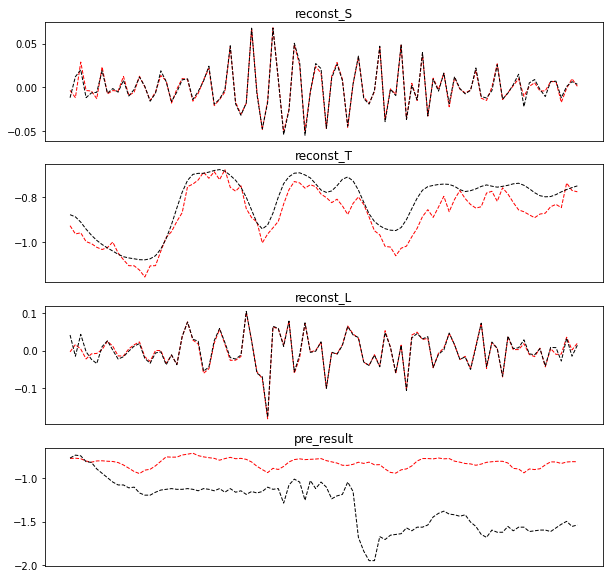

In [12]:
test(train_model)

In [13]:
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
print("train end：", formatted_time)

train end： 2024-07-04 15:15:59


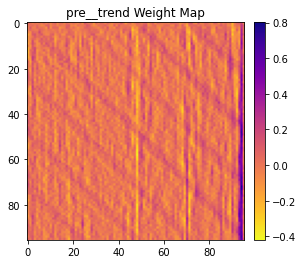

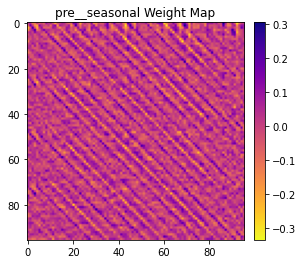

In [14]:
model_path = checkpoint_path+"checkpoint.pth"
if os.path.exists(model_path):
    weights = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(weights)
    weights_list = {}
    weights_list['pre__trend'] = model.l1.weight.detach().cpu().numpy()
    weights_list['pre__seasonal'] = model.l2.weight.detach().cpu().numpy()
    checkpoint_path = './{}_weight/{}/'.format(dataset,pre_len)

    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path, exist_ok=True)

    for w_name, weight in weights_list.items():
        fig, ax = plt.subplots()
        im = ax.imshow(weight, cmap='plasma_r')
        fig.colorbar(im, pad=0.03)
        plt.title(f'{w_name} Weight Map')
        plt.savefig(os.path.join(checkpoint_path, f'{w_name}_weight_map.png'), dpi=500)
        plt.show()
